# บทที่ 3 - Stochastic Gradient Descent ตั้งแต่เริ่มต้น

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ai-builders/curriculum/blob/main/notebooks/03_sgd_from_scratch.ipynb)

ในบทเรียนนี้ เราจะทำการสร้างวิธีที่โมเดลของเราเรียนรู้ในบทเรียนที่แล้วๆมา เรียกว่า stochastic gradient descent ขึ้นมาเองตั้งแต่ต้นโดยใช้เพียงแค่ Pytorch สำหรับ linear algebra และการทำ partial derivatives เท่านั้น ด้วยตัวอย่างการจำแนกรูปภาพตัวเลข 3 และ 7 ออกจากกัน

บทเรียนแปล-สรุปมาจาก [04_mnist_basics.ipynb](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) ของ [fastai](https://course.fast.ai/) ผู้ที่สนใจสามารถไปติดตามบทเรียนต้นทางได้ที่ [course.fast.ai](https://course.fast.ai/)

In [1]:
#ติดตั้ง fastai
!pip install -q fastbook==0.0.29
import fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from fastai.vision.all import *
from fastbook import *
import torch

matplotlib.rc('image', cmap='Greys')

#fix plot_function as new pytorch requires steps argument for torch.linspace
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min, max, steps=100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))

# เทรนโมเดลจำแนกรูปเลข 3 และเลข 7 จาก [ชุดข้อมูล MNIST](http://yann.lecun.com/exdb/mnist/)

## โหลดข้อมูลรูปเลข 3 และเลข 7

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
#แบ่งเป็น train, validation, test 
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

In [6]:
#ในแต่ละ set จะมีเลข 3 และ 7
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

In [7]:
#ในละ folder 3 และ 7 จะเป็นไฟล์รูป
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [8]:
#จำนวนรูปในแต่ละ class
len(threes), len(sevens)

(6131, 6265)

In [9]:
im3_path = threes[6000]
im3 = Image.open(im3_path)
im3

In [10]:
#รูปขนาด 28 x 28 pixels 
array(im3).shape

(28, 28)

In [11]:
#เปลี่ยนจาก numpy array
array(im3)[4:10,4:10]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=uint8)

In [12]:
#เป็น torch tensor
tensor(im3)[4:10,4:10]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

In [13]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,37,67,156,209,254,255,246,48
2,0,0,0,0,0,0,0,0,34,118,239,253,253,253,253,254,253,226
3,0,0,0,0,0,0,14,175,247,253,254,253,253,210,205,254,253,253
4,0,0,0,0,0,0,126,253,253,253,214,130,49,15,122,254,234,116
5,0,0,0,0,0,0,95,223,162,80,0,0,0,9,208,254,173,0
6,0,0,0,0,0,0,0,0,0,0,0,5,89,246,254,173,0,0
7,0,0,0,0,0,0,0,0,0,0,5,38,253,253,237,15,0,0
8,0,0,0,0,0,0,0,0,0,0,89,253,253,180,40,0,0,0
9,0,0,0,0,0,0,0,0,0,106,246,250,183,9,0,0,0,0


## วิธีที่ง่ายที่สุด: ดูว่ามี pixel เหมือนกันแค่ไหน

สมมุติเราไม่ทำ ML อะไรเลย แต่เราพยามสร้างกฎแบบ Rule-based Systems โดยบอกว่า "รูปที่มี pixels ใกล้เคียงกับ pixels เฉลี่ยของเลข 3 และ 7 มากกว่า ให้ถือว่าเป็นเลขนั้น"

In [14]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

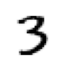

In [15]:
show_image(three_tensors[1]);

In [16]:
#เรามัดเลข 3 และ 7 ทั้งหมดรวมกันตามคลาสแล้วหารมันด้วย 255 เพื่อให้ได้ค่าระหว่าง 0 และ 1
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [17]:
len(stacked_threes.shape)

3

In [18]:
stacked_threes.ndim

3

<Axes: >

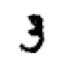

In [19]:
#เลข 3 ที่ index 0
show_image(stacked_threes[0,:,:])

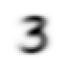

In [20]:
#เลข 3 โดยเฉลี่ย
mean3 = stacked_threes.mean(0)
show_image(mean3);

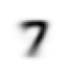

In [21]:
#เลข 7 โดยเฉลี่ย
mean7 = stacked_sevens.mean(0)
show_image(mean7);

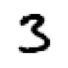

In [22]:
#เลข 3 อันที่ 125
a_3 = stacked_threes[125]
show_image(a_3);

เราจะเห็นได้ว่าหากเราคำนวน mean absolute error และ mean squared error ของแต่ละ pixel ระหว่าง "เลข 3 อันที่ 125" กับ "เลข 3 โดยเฉลี่ย" และ "เลข 7 โดยเฉลี่ย" เราจะเห็นกว่าค่าของ "เลข 3 อันที่ 125" กับ "เลข 3 โดยเฉลี่ย" มีค่าน้อยกว่า และในกรณีนี้ระบบ (ที่ไม่ใช่ ML) ของเราจะทำนายถูกว่า "เลข 3 อันที่ 125" คือเลข 3

In [23]:
#ความห่างระหว่า "เลข 3 อันที่ 125" กับ "เลข 3 โดยเฉลี่ย"
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1259), tensor(0.2290))

In [24]:
#ความห่างระหว่า "เลข 3 อันที่ 125" กับ "เลข 7 โดยเฉลี่ย"
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1836), tensor(0.3390))

In [25]:
#ใช้ function ของ pytorch คิดก็ได้
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1836), tensor(0.3390))

เรื่องน่าคิดถึงความแตกต่างระหว่าง mean squared error และ mean absolute error

In [26]:
a = torch.tensor([1, 2, 3]).float()
b = torch.tensor([2.,3.,4.5])
c = torch.tensor([2.,3.,40.])

#mse และ mae ไม่ต่างกันเท่าไหร่สำหรับ a และ b
(a-b).abs().mean().item(), \
((a-b)**2).mean().sqrt().item(),

(1.1666666269302368, 1.1902379989624023)

In [27]:
#mse และ mae ต่างกันเกือบเท่าตัวสำหรับ a และ c
(a-c).abs().mean().item(),\
((a-c)**2).mean().sqrt().item()

(13.0, 21.3775577545166)

## Stochastic Gradient Descent (SGD)

หากยังจำได้จากบทที่ 1 เราเรียนรู้ว่าเราจะคำนวณ `Gradients` จาก `Loss` แล้วให้ Optimizer ทำหน้าที่ update `Weights` ในบทเรียนนี้เราจะมาเรียนรู้ขั้นตอนเหล่านี้กัน

<img src=https://github.com/ai-builders/curriculum/raw/main/images/training_loop50.png width="700px">

### คำนวณ Gradients เพื่อทำ Backpropagation

หากคุณยังไม่เคยเรียนเกี่ยวกับ [partial derivative](https://en.wikipedia.org/wiki/Partial_derivative) และ [chain rule](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/a/chain-rule-review) ในชั้นเรียนมัธยมปลาย คุณอาจจะไม่จำเป็นต้องเข้าใจเนื้อหาส่วนนี้ทั้งหมดก็ได้ ใจความสำคัญคือเราสามารถปรับแต่ง `Weights` ได้ด้วย `Gradients` ที่ถูกคำนวณมาจาก `Loss` เพื่อให้ได้ `Loss` ที่น้อยที่สุดเท่าที่จะทำได้ใน iteration ต่อๆไป

ตัวอย่างการทำ Backpropagation อย่างง่ายจาก [cs231n](https://cs231n.github.io/optimization-2/#backprop)

Independent variables:
(เราอาจจะคิดว่า `x, y, z` เป็น `Inputs` หรือ `Weights` สำหรับโมเดลก็ได้)
\begin{align}
x & = -2 \\
y & = 5 \\
z & = -4 \\
\end{align}

Dependent variables: 
(`q` และ `f` คือฟังชั่นอะไรบางอย่าง เช่น `Loss Function` ของโมเดลก็ได้)

ถ้าแทนค่า `x, y, z` เข้าไปในฟังชั่น `q, f` จะได้

\begin{align}
q & = x+y = -2+5 = 3\\
f & = q*z = 3*-4 = -12
\end{align}

การทำแบบนี้เปรียบเสมือนการเปลี่ยน `Inputs` เป็น `Predictions` ด้วย `Weights` เรียกว่า `Forward Pass`

หลังจากนั้น เราสามารถคำนวณหา `Gradients` ซึ่งโดยทั่วไปแล้วหมายถึงค่าอัตราการเปลี่ยนแปลงของฟังชั่นท้ายสุด (ในที่นี้คือ `f`) เทียบกับตัวแปรแรกสุด (ในที่นี้คือ `x, y, z`) ได้แก่ $\frac{df}{dx}$, $\frac{df}{dy}$, $\frac{df}{dz}$ เราสามารถหาสิ่งนี้ด้วยการหา [partial derivative](https://en.wikipedia.org/wiki/Partial_derivative) และ [chain rule](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/a/chain-rule-review) เรียกว่า `Backward Pass`

\begin{align}
\frac{df}{dq} & = z = -4\\
\frac{dq}{dx} & = 1\\
\frac{df}{dx} & = \frac{df}{dq} * \frac{dq}{dx}\\
& = -4*1\\
& = -4\\
\end{align}



In [28]:
# set some inputs
x = -2; y = 5; z = -4

# perform the forward pass
q = x + y # q becomes 3
f = q * z # f becomes -12

# perform the backward pass (backpropagation) in reverse order:
# first backprop through f = q * z
dfdz = q # df/dz = q, so gradient on z becomes 3
dfdq = z # df/dq = z, so gradient on q becomes -4
# now backprop through q = x + y
dfdx = 1.0 * dfdq # dq/dx = 1. And the multiplication here is the chain rule!
dfdy = 1.0 * dfdq # dq/dy = 1

dfdx, dfdy

(-4.0, -4.0)

Pytorch สามารถทำ `Backward Pass` ให้เราโดยอัตโนมัติด้วยฟังชั่น Autograd โดยที่เราไม่ต้องคิด partial derivative เอง ผลข้างเคียงอีกอย่างคือเราสามารถใช้ Pytorch ช่วยทำการบ้านวิชาแคลคูลัสเวลาเราหา derivative ที่ยากเกินไปไม่ออกได้อีกด้วย

In [29]:
xt = torch.tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [30]:
#ฟังชั่น f(x) = (x1^2 + x2^2 +...+xn^2)
def f(x): return (x**2).sum()

yt = f(xt) #ใส่ 3, 4, 10 เข้าไปได้ 3^2+4^2+10^2 = 125
yt

tensor(125., grad_fn=<SumBackward0>)

In [31]:
#ถ้าคิดด้วยมือ df(x)/dx = 2x 
#สำหรับ x1=3, x2=4, x3=10 ก็จะเป็น 
#df(x1)/dx1 = 6, df(x2)/dx2 = 8, df(x3)/dx3 = 20

#ใช้ autograd หา df(x1)/dx1, df(x2)/dx2, df(x3)/dx3
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

## สร้าง Loss Function สำหรับจำแนกรูปเลข 3 และเลข 7

#### สร้าง X และ y

จัดการ `Inputs` คือรูปตัวเลข 28x28 pixels และ `Labels` คือ `1 ถ้าเป็นเลข 3` และ `0 ถ้าเป็นเลข 7`

In [32]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [33]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [34]:
#เราสามารถนำ iterables สองอันมาต่อกันแบบนี้ได้ด้วย zip
a = [1,2,3]
b = [4,5,6]
list(zip(a,b))

[(1, 4), (2, 5), (3, 6)]

In [35]:
dset = list(zip(train_x,train_y))
example = dset[0]

#คู่ Inputs　และ Labels
example[0].shape, example[1].shape

(torch.Size([784]), torch.Size([1]))

In [36]:
#สร้าง validation set ในแบบเดียวกัน
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

#### Initiate `Weights`

สมมุติว่าเราจะใช้ architecture สุดเรียบง่าย แค่คูณค่า pixels ของรูป `Inputs` ด้วย `W` และบวกด้วย `b`

$$prediction = \Sigma(xW^T) + b$$

เราสามารถเริ่มตั้ง `Weights` เป็นการ random จาก standard normal distribution

In [37]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [38]:
#Inputs มี dimension (batch_size, 28*28)
#เพราะงั้นถ้าเราจะคูณรายตัว (element-wise multiplication) ด้วย W^T, W ต้องมี dimension (28*28,1)
weights = init_params((28*28,1))
weights.shape

torch.Size([784, 1])

In [39]:
#bias มีแค่ (1) dimension แล้วจะถูก broadcast ไปทุก dimension ของ batch size เอง
# (1) -> (batch_size,1)
bias = init_params(1)
bias

tensor([0.3472], requires_grad=True)

In [40]:
weights.shape, bias.shape, train_x.shape, train_x[7].shape

(torch.Size([784, 1]),
 torch.Size([1]),
 torch.Size([12396, 784]),
 torch.Size([784]))

#### Forward Pass

In [41]:
#คำนวณ forward pass สำหรับตัวอย่าง 7
(train_x[7]*weights.T).sum(1)[:,None] + bias

tensor([[-15.2588]], grad_fn=<AddBackward0>)

In [42]:
#คำนวณ forward pass สำหรับทุกตัวอย่าง
(train_x*weights.T).sum(1)[:,None] + bias

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

In [43]:
#เขียนเป็นฟังชั่น; @ คือ matrix multiplication ใน pytorch
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

#### Metric ใช้ Accuracy

In [44]:
#ถ้าสมมุติว่า Predictions >0 ให้ทายเป็น 1 (เลข 3)
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [45]:
from collections import Counter
Counter((preds>0.0).float().numpy()[:,0])

Counter({0.0: 10788, 1.0: 1608})

In [46]:
#จะเห็นได้ว่ามันถูกเครื่องๆ (เพราะเราเดาสุ่มด้วย weights ที่สุ่มมา)
corrects.float().mean().item()

0.5379961133003235

In [47]:
#ถ้าเราเปลี่ยน weights เล็กน้อย
with torch.no_grad():
    weights *= 5.0001
    bias+=10

In [48]:
#ความแม่นยำก็เปลี่ยนนิดนึง
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.548402726650238

#### Loss Function อย่างง่าย

In [49]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [50]:
#loss function ที่จะเป็นจะเป็น Predictions ของ class ที่ผิด
#เพราะงั้นยิ่งทาย class ที่ผิดแบบมั่นใจมาก Loss ก็จะยิ่งสูง
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [51]:
#if target == 1, loss is how far it is from 1
#if target == 0, loss is how far it is from 0
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [52]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [53]:
#ถ้าทายแม่นขึ้น loss ก็ลดลง
mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

tensor(0.2333)

### Activation Function - Sigmoid

ปัญหาอย่างนึงของเราตอนนี้คือโมเดลเราให้ค่า `Predictions` เป็นจำนวนจริง แต่ `Loss Function` ของเราต้องการค่าระหว่าง 0 ถึง 1 เราจึงใช้ `Activation Function` ที่ชื่อ Sigmoid เพื่อเปลี่ยนให้ตัวเลขอยู่ระหว่าง 0 ถึง 1

`Activation Function` นั้นมีมากมายหลายประเภท ที่นิยมใช้ เช่น [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))(x) - ฟังชั่นที่บอกว่าถ้าน้อยกว่า 0 ให้เป็น นอกนั้นเป็น x, [tanh](https://mathworld.wolfram.com/HyperbolicTangent.html)(x) - ฟังชั่นที่เปลี่ยนค่าจำนวนจริงให้อยู่ระหว่าง -1 และ 1 เป็นต้น อ่านเพิ่มเกี่ยวกับ [Activation Functions](https://en.wikipedia.org/wiki/Activation_function)

In [54]:
def sigmoid(x): return 1/(1+torch.exp(-x))

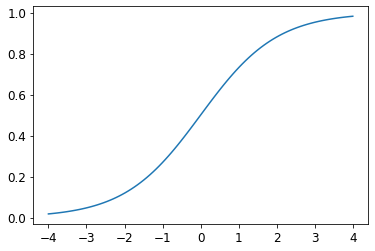

In [55]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [56]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() #ใส่ sigmoid ไป; pytorch tensor มี built-in function ให้แล้ว
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

หลายครั้งข้อมูลทั้งชุดของเราใหญ่เกินไปที่จะใส่เข้าไปใน memory ของเครื่อง เราจึงต้องใส่เข้าไปทีละ batch ด้วย `DataLoader`

In [57]:
#ทดลองใช้ Dataloader สุ่มตัวเลขจาก 0-14; batch ละ 5 ตัวอย่าง; ให้สุ่มด้วย
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [58]:
#สมมุติเรามี DataSet　แบบนี้
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [59]:
#ก็ใส่เข้าไปใน dataloader ได้เช่นกัน
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## Putting It All Together

#### Initialize weights

In [60]:
weights = init_params((28*28,1))
bias = init_params(1)

#### Initialize dataloader

In [61]:
#สร้าง dataloader สำหรับ train
dl = DataLoader(dset, batch_size=256, shuffle=True)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [62]:
#เราจะไม่ shuffle validation set
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=False)

In [63]:
#(batch size, 28*28)
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

#### Forward pass

In [64]:
def linear1(xb): return xb@weights + bias
preds = linear1(xb)
preds.shape

torch.Size([256, 1])

#### Calculate loss

In [65]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()
loss = mnist_loss(preds, xb)
loss

tensor(0.7690, grad_fn=<MeanBackward0>)

#### Backward pass - get gradients and update weights

In [66]:
loss.backward()
weights.grad.shape,weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(0.0049), tensor([0.0425]))

In [67]:
#คำนวณ gradient ด้วย .backward()
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [68]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0007), tensor([0.0070]))

In [69]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0064), tensor([-0.0285]))

In [70]:
#เราจำเป็นต้อง reset gradients เพื่อไม่ให้มันบวกเพิ่มขึ้นเรือ่ยๆ
weights.grad.zero_();
bias.grad.zero_();

In [71]:
#เทรน 1 epoch
def train_epoch(model, lr, params):
    #โยนทุก batch ให้โมเดลที่ละ batch จนหมด
    for xb,yb in dl:
        #คำนวน loss และ gradients
        calc_grad(xb, yb, model)
        #เปลี่ยน weights ด้วย gradient * learning rate (lr)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [72]:
#คิด accuracy
((preds>0.0).float() == yb).float().mean()

tensor(0.5469)

###  Calculate metric (accuracy in this case)

In [73]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [74]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

In [75]:
#ทำการ validate ด้วย validation set
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [76]:
validate_epoch(linear1)

0.5485

In [77]:
#เทรนไป 1 epoch; accuracy เพิ่มเกือบเท่าตัว!
lr = 1.

params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.9253

In [78]:
#เทรนไป 20 epoch; ทายถูกเกือบหมด
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.9553 0.9608 0.9632 0.9657 0.9681 0.9696 0.9716 0.973 0.974 0.974 0.975 0.9774 0.9745 0.976 0.9779 0.9779 0.9784 0.9784 0.9784 0.9789 

### Optimizer as a class

หลายครั้งเรารวบรวมหน้าที่การ update weights มาเป็น class ชื่อ optimizer

In [79]:
#nn.Linear ก็คือฟังชั่นที่ x*W.T + b เราเขียนเมื่อกี้เลย
linear_model = nn.Linear(28*28,1, bias=True)
linear_model

Linear(in_features=784, out_features=1, bias=True)

In [80]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [81]:
#optimizer　แบบง่ายที่สุด
class BasicOptim:
    def __init__(self,params,lr): 
        self.params,self.lr = list(params),lr

    #step ทำการ update weights
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    #zero grad เพื่อทำการรีเซต gradients
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [82]:
opt = BasicOptim(linear_model.parameters(), lr)

In [83]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        #เปลี่ยนโค้ดเป็น optimizer แทน
        opt.step()
        opt.zero_grad()

In [84]:
validate_epoch(linear_model)

0.3566

In [85]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [86]:
#ได้ผลดีเหมือนเดิม
train_model(linear_model, 20)

0.9706 0.975 0.975 0.9779 0.9779 0.9784 0.9794 0.9794 0.9799 0.9804 0.9804 0.9804 0.9804 0.9814 0.9819 0.9824 0.9824 0.9819 0.9824 0.9829 

## ทำงานง่ายขึ้นด้วย PyTorch

Pytorch ได้ทำการเปลี่ยนฟังชั่นและ class ต่างๆที่เราใช้งานเป็นฟังชั่นพื้นฐานของ package ให้เราเรียกใช้ได้

In [87]:
linear_model = nn.Linear(28*28,1,bias=False) #เหมือนกับ init_weights และการคูณ matrix ที่เราเพิ่งทำไป
opt = SGD(linear_model.parameters(), lr) #เหมือนกับ BasicOptim ที่เราเพิ่งทำไป

#เทรนโมเดลได้ผลดีเหมือนเดิม
train_model(linear_model, 20)

0.9725 0.9755 0.976 0.976 0.9769 0.9764 0.9789 0.9799 0.9789 0.9789 0.9799 0.9799 0.9794 0.9804 0.9804 0.9809 0.9803 0.9809 0.9824 0.9813 

## ใช้ fastai ให้สะดวกยิ่งขึ้น

In [88]:
dls = DataLoaders(dl, valid_dl)
#รวมทุกอย่างเข้าด้วยกันด้วย class Learner
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [89]:
learn.fit(20, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.059673,0.041307,0.972031,00:00
1,0.040368,0.034897,0.975466,00:00
2,0.032661,0.032365,0.974975,00:00
3,0.028252,0.029463,0.977429,00:00
4,0.025178,0.028448,0.977920,00:00
5,0.023642,0.027670,0.977920,00:00
6,0.022653,0.026340,0.978410,00:00
7,0.021488,0.025264,0.979882,00:00
8,0.020988,0.024670,0.979392,00:00
9,0.020430,0.024237,0.979392,00:00


## สร้าง Architecture ที่ Deep ขึ้น

In [90]:
#แทนที่จะทำ matrix multipilcation + bias ครั้งเดียว เราใส่ ReLU activation ไปเพิ่ม
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0)) #นี่คือ relu
    res = res@w2 + b2 #แล้วทำ matrix multiplication + bias อีกรอบ
    return res

In [91]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

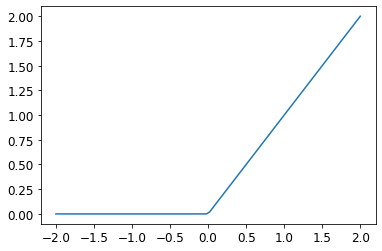

In [92]:
plot_function(F.relu)

In [93]:
#แน่นอนว่าอ่านง่ายกว่าถ้าใช้ pytorch แทนที่จะเขียนฟังชั่นเอง
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [94]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [95]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.253839,0.101416,0.962709,00:00
1,0.118263,0.055467,0.969578,00:00
2,0.071047,0.044955,0.970559,00:00
3,0.050435,0.039946,0.972031,00:00
4,0.039966,0.036746,0.972522,00:00
5,0.034656,0.034883,0.973994,00:00
6,0.030598,0.033072,0.974485,00:00
7,0.028436,0.031563,0.974485,00:00
8,0.026895,0.030731,0.975957,00:00
9,0.025961,0.029774,0.977429,00:00


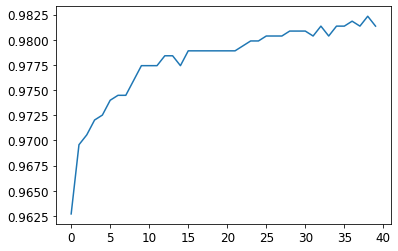

In [96]:
#ดู accuracy เพิ่มขึ้นเรื่อยๆ
plt.plot(L(learn.recorder.values).itemgot(2));

In [97]:
learn.recorder.values[-1][2]

0.981354296207428

## ไปให้ Deep กว่านั้นอีก

แทนที่เราจะใช้ Architecture ง่ายๆที่เราคิดขึ้นเอง เรามาลองใช้ Architecture ที่ซับซ้อนขึ้นอย่าง `resnet18` กัน

In [98]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)

#เทรนแค่ epoch เดียวก็ดีกว่าเทรน 20-40 epoch เมื่อกี้แล้ว
learn.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.098986,0.027636,0.994603,00:27


# Checkpoint ท้ายบท

### ☑️ ดูวิดีโอ [3Blue1Brown](https://www.youtube.com/watch?v=IHZwWFHWa-w) เกี่ยวกับ SGD (มีซับไทย)

วิดีโอนี้จะอธิบายการทำงานของ SGD ใน Neural Networks ที่เราเรียนกันในบทที่ 1 และ 3 ด้วยกราฟฟิคที่สวยงาม ช่วยเพิ่มความเข้าใจได้มากยิ่งขึ้น

Youtube Link: [https://www.youtube.com/watch?v=IHZwWFHWa-w](https://www.youtube.com/watch?v=IHZwWFHWa-w)

## คำถามชวนคิดเกี่ยวกับบทเรียน

1. เราได้เรียนรู้การทำงานเกือบทุกส่วนของ ML Models ในบทเรียนนี้ คุณคิดว่าสำหรับโครงงานของคุณ การปรับแต่งส่วนไหนของโมเดลจะทำให้ได้ผลดีเพิ่มขึ้นมากที่สุด

2. คุณคิดว่าการ initialize weights มีผลต่อคุณภาพของโมเดลที่ถูกเทรนหรือไม่ หากไม่ใช้ weights แบบสุ่ม เราควรใช้ weights อะไรในการเริ่มเทรนโมเดล

3. Loss กับ Metric ต่างกันอย่างไร ทำไมคุณคิดว่าเราถึงเทรนโมเดลเพื่อให้ได้ Loss ที่ดีที่สุด แต่กลับวัดผลมันด้วย Metric

4. คุณคิดว่า `Activation Function` มีความสำคัญอย่างไรกับประสิทธิภาพของโมเดล ML เราควรเลือกใช้อันไหนในกรณีไหน

5. คุณคิดว่าทำไม Architecture อย่าง resnet18 ถึงทำได้ดีกว่า Architecture ที่เราสร้างขึ้นมาเองง่ายๆ ทั้งที่เทรนแค่ 1 epoch เทียบกับที่เราเทรนถึง 20-40 epochs

6. คุณคิดว่ามีการ update weights ที่ดีกว่าเอา gradients มาลบไปทีละ iteration อย่างที่เราทำหรือไม่ คิดว่าวิธีไหนบ้าง หรือเป็นไปได้ไหมที่เราจะเทรนโมเดลโดยไม่ใช้ backpropagation กล่าวคือ update weights โดยไม่ใช้ gradients






## สิ่งที่ควรเตรียมพร้อมสำหรับทำโครงงาน

### ☑️ ทบทวนระบบการให้คะแนนโครงงานให้เรียบร้อย

AI Builders จะออกใบประกาศนียบัตรจบการศึกษาให้กับผู้เข้าร่วมโครงการที่ส่งโครงงานได้คะแนนอย่างน้อย 70 จาก 100 คะแนนตามเกณฑ์ต่อไปนี้เท่านั้น

1. problem statement; เหตุผลในการแก้ปัญหาเชิงธุรกิจ/ชีวิตประจำวันด้วย machine learning - 15 คะแนน
2. metrics and baselines; การให้เหตุผลเชื่อมโยงการแก้ปัญหากับตัวชี้วัดที่เลือก / การวัดผลเทียบกับวิธีแก้ปัญหาในปัจจุบัน - 15 คะแนน
3. data collection and cleaning; การเก็บและทำความสะอาดข้อมูล - 15 คะแนน

**วันนี้เราจะคิดถึง 2 ข้อนี้เป็นพิเศษ**

**4. exploratory data analysis; การทำความเข้าใจข้อมูล - 20 คะแนน**

**5. modeling, validation and error analysis; การทำโมเดล, ทดสอบโมเดล และวิเคราะห์ข้อผิดพลาดของโมเดล - 20 คะแนน**

6. deployment; การนำโมเดลไปใช้แก้ปัญหาจริง - 15 คะแนน

### ☑️ เข้าใจชุดข้อมูล

คุณรู้เกี่ยวกับ labels ที่คุณกำลังทำนายแค่ไหน 
* ถ้าเป็น classification มันมี labels กี่ประเภท (class) แต่ละตัวอย่างเป็นได้มากกว่าหนึ่งประเภท (multi-label) หรือได้แค่ประเภทเดียว (multi-class) 
* ถ้าเป็น regression แล้ว labels ของคุณกระจายตัวยังไง
* คุณมีตัวอย่างพอในแต่ละ class ให้โมเดลเรียนรู้หรือเปล่า

features ของคุณหน้าตาเป็นอย่างไร

* ถ้าเป็นรูปภาพ เป็นรูปจากมุมมองเดียวหรือหลายมุมมอง ขนาดรูป-ความละเอียดเท่ากันไหม
* ถ้าเป็นข้อความ การกระจายตัวของคำเป็นยังไง ทั้ง word count และ tfidf; คำที่เกิดบ่อยๆในแต่ละ labels คืออะไร
* ถ้าเป็นข้อมูลตาราง การกระจายตัวของ feature ที่เป็นตัวเลข (numerical) และประเภท (categorical) เป็นอย่างไรบ้าง ลองหา correlation ระหว่าง features ด้วยกัน และ feature กับ labels ดูว่ามีอะไรน่าสนใจไหม



### ☑️ เทรนโมเดลแรกให้จบจนเห็นผลลัพธ์เร็วที่สุดเท่าที่จะทำได้

แน่นอนว่าการทำความสะอาดข้อมูลและการทำความเข้าใจข้อมูลเป็นสิ่งสำคัญ (คะแนนรวม 15+20=35) แต่วิธีที่ดีที่สุดที่จะรู้ว่าโมเดลของเราทำได้ดีแค่ไหนคือการลองเทรนไปเลยทั้งๆที่ไม่ต้องทำอะไรกับข้อมูลมาก หลังจากนั้นเราอาจจะมาไล่ดูข้อผิดพลาดของโมเดลเพื่อให้มีไอเดียในการจัดการข้อมูลและโมเดลต่อไปได้ 

คุณอาจจะคิดว่าการสร้าง ML model มีขั้นตอนแบบนี้:

<img src=https://github.com/ai-builders/curriculum/raw/main/images/ml_what_you_think_it_is.png width="500px">

แต่จริงๆแล้วมันคือแบบนี้:

<img src=https://github.com/ai-builders/curriculum/raw/main/images/ml_what_it_really_is.png width="500px">

เพราะฉะนั้นอย่ากลัวที่จะลองทำให้ครบขั้นตอนก่อนแล้วจึงย้อนกลับไปกลับมาเพื่อทำใหม่ให้ดียิ่งขึ้น